!["Logo"](https://github.com/Fortuz/rl_education/blob/main/assets/logo.png?raw=1)

Created by **Domonkos Nagy**

[<img src="https://colab.research.google.com/assets/colab-badge.svg">](https://colab.research.google.com/github/Fortuz/rl_education/blob/main/10.%20Off-policy%20Control/atari_breakout.ipynb)

# Atari Breakout (solution)

Breakout is a famous Atari game. The dynamics are similar to pong: You move a paddle and hit the ball in a brick wall at the top of the screen. Your goal is to destroy the brick wall. You can try to break through the wall and let the ball wreak havoc on the other side, all on its own! You have five lives.

<img src="https://github.com/Fortuz/rl_education/blob/main/10.%20Off-policy%20Control/assets/breakout.gif?raw=1" width="300"/>

This environment runs the actual Atari game in an emulator. The observation space is `Box(0, 255, (210, 160, 3), np.uint8)`, meaning we have a 210x160 RGB image at every time step. There are 4 possible actions: NOOP, FIRE, RIGHT and LEFT, where FIRE is only used to start a new round after the ball has fallen down. You get rewards for destroying bricks in the wall, different color bricks yield different rewards. For a more detailed documentation, see the AtariAge page linked below.

This notebook uses *Deep Q-Learning (DQN)* to train an agent to play Breakout. We will follow the original DQN paper (Human-level control through deep reinforcement learning, Mnih et. al.)
closely with our implementation, and thus **it is highly recommended to read the paper before getting started with the notebook!** It is also recommended to run this notebook on Colab for much faster training times.

- Read the DQN paper here: https://web.stanford.edu/class/psych209/Readings/MnihEtAlHassibis15NatureControlDeepRL.pdf
- Documentation for the Atari Breakout environment: https://gymnasium.farama.org/environments/atari/breakout/
- Description of the game: https://atariage.com/manual_html_page.php?SoftwareID=889

In [ ]:
# Install dependencies if running in Colab
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install gymnasium[atari,accept-rom-license]==0.29.0
    !pip install gymnasium==0.29.0

In [ ]:
from torch import nn
import torch
import gymnasium as gym
from gymnasium.wrappers import AtariPreprocessing, FrameStack, RecordVideo
from collections import deque
import numpy as np
from tqdm.notebook import trange
import torch.nn.functional as F
import random
import ipywidgets as widgets
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Device: {device}')

Device: cuda


## Hyperparameters

These parameters are set up by default so that you can train a decent agent in about 3 hours using the free GPUs provided by Colab. This code block more or less mirrors page 10 of the paper, but there are some differences,
for example we use epsiodes instead of overall time steps as the unit of measurement.

In [ ]:
FRAME_SKIP = 4  # Repeat each action selected for this many frames
N_EPISODES = 4_000 # Number of training episodes
BATCH_SIZE = 32  # SGD batch size
BUFFER_SIZE = 1_000_000 // FRAME_SKIP  # Size of the replay memory
HISTORY_LENGTH = 4  # Number of frames given to the Q-network
GAMMA = 0.99  # Discount factor
OPTIM_FREQ = 4  # Optimize after this many action selections
ALPHA = 0.00005  # Learning rate
EPSILON = 1.0  # Initial exploration
EPSILON_MIN = 0.01  # Final exploration
EPSILON_DECAY = 4 * (EPSILON - EPSILON_MIN) / (3 * N_EPISODES)  # Exploration decay rate
MIN_REPLAY_SIZE = 50_000 // FRAME_SKIP  # Minimum size of the replay memory
NOOP_MAX = 30  # Maximum number of NOOP actions take by the agent at the start of each episode
TARGET_UPDATE_FREQ = 10_000  # Update the target network with the online network's weights this frequently
SAVE_FREQ = N_EPISODES // 50  # Model saving frequency
N_RECORDINGS = 5  # Number of episodes to record
REC_EPISODES = np.linspace(0, N_EPISODES-1, num=N_RECORDINGS, dtype=int)  # Episodes to record

## Nature CNN

This class defines the network architecture described in the paper, commonly called the "Nature CNN".
The `act` method runs a forward pass on the state it receives as an argument, and returns the argmax
of the resulting action values.

<img src="https://github.com/Fortuz/rl_education/blob/main/10.%20Off-policy%20Control/assets/cnn.png?raw=1" width="700"/>

*Figure from the DQN paper. Note that for Breakout specifically, we only need 4 output nodes.*

In [ ]:
class Net(nn.Module):
    def __init__(self, env, device):
        super(Net, self).__init__()
        self.device = device
        # Input and output shape
        in_channels = env.observation_space.shape[0]
        out_channels = int(env.action_space.n)
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        # Linear layers
        self.fc1 = nn.Linear(7 * 7 * 64, 512)
        self.fc2 = nn.Linear(512, out_channels)

    def forward(self, x):
        # Convolution 1
        x = self.conv1(x)
        x = F.relu(x)
        # Convolution 2
        x = self.conv2(x)
        x = F.relu(x)
        # Convolution 3
        x = self.conv3(x)
        x = F.relu(x)
        # Flattening, linear layers
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

    # Return the action with the highest Q-value for the input state
    def act(self, state):
        with torch.no_grad():
            state_t = torch.as_tensor(np.array(state), dtype=torch.float32, device=self.device)
            q_values = self(state_t.unsqueeze(0))
        return torch.argmax(q_values[0]).item()

## Replay Memory

The replay memory stores transitions, i. e. $(S, A, R, S')$ tuples. In practice, we also need to store whether the transition terminated the episode, so our tuples have 5 elements.
Upon initialization, a random policy is used to fill the buffer to its minimal size. The `append` method stores a transition (5-element tuple) in the memory, while the `sample`
method returns `batch_size` transitions sampled randomly from the buffer as a tuple of 5 PyTorch tensors.

In [ ]:
class ReplayMemory():
    def __init__(self, env, min_size, max_size, device):
        self.device = device
        self.transitions = [None] * max_size

        self.idx = 0
        self.min_size = min_size
        self.max_size = max_size
        self.full = False
        self._initialize(env)

    # Run random policy for min_size steps to fill up the buffer
    def _initialize(self, env):
        state, _ = env.reset()

        for _ in trange(self.min_size):
            action = env.action_space.sample()

            new_state, reward, terminated, truncated, _ = env.step(action)

            transition = (state, action, reward, new_state, terminated)
            self.append(transition)
            state = new_state

            if terminated or truncated:
                state, _ = env.reset()

    # Append a transition to the buffer
    def append(self, transition):
        self.transitions[self.idx] = transition

        self.idx = (self.idx + 1) % self.max_size
        self.full = self.full or self.idx == 0

    # Sample batch_size random transitions from the buffer
    def sample(self, batch_size):
        size = self.max_size if self.full else self.idx
        indices = np.random.randint(0, high=size, size=(batch_size,))

        states = np.array([self.transitions[i][0] for i in indices])
        actions = np.array([[self.transitions[i][1]] for i in indices])
        rewards = np.array([[self.transitions[i][2]] for i in indices])
        new_states = np.array([self.transitions[i][3] for i in indices])
        terminateds = np.array([[self.transitions[i][4]] for i in indices])

        states_t = torch.as_tensor(states, dtype=torch.float32, device=self.device)
        actions_t = torch.as_tensor(actions, dtype=torch.int64, device=self.device)
        rewards_t = torch.as_tensor(rewards, dtype=torch.float32, device=self.device)
        new_states_t = torch.as_tensor(new_states, dtype=torch.float32, device=self.device)
        terminateds_t = torch.as_tensor(terminateds, dtype=torch.float32, device=self.device)

        return states_t, actions_t, rewards_t, new_states_t, terminateds_t

## Preprocessing

The `AtariPreprocessing` and `FrameStack` wrappers implement the preprocessing pipeline described in the paper. Using these wrappers, we resize each frame to 84x84 pixels and apply a grayscale filter,
as well as repeat each action `FRAME_SKIP` (default: 4) times. In addition, we stack the last `HISTORY_LENGTH` (default: 4) frames, so the state
is represented by the last 4 observations the agent experienced. Other preprocessing steps (described in the paper) are also applied.
Below is a comparison of an observation before and after the preprocessing pipeline.

In [ ]:
# Initialize environment with preprocessing
def initialize_env(recording=False, show_comparison=False):
    # Create base environment
    env = gym.make('ALE/Breakout-v5', render_mode='rgb_array',
               frameskip=1, repeat_action_probability=0)
    env.metadata['render_fps'] = 60

    # Show state before preprocessing
    if show_comparison:
        plt.figure(figsize=(11, 6))
        plt.suptitle("The state before vs. after preprocessing", fontsize="x-large")
        env.reset()
        obs = env.step(1)[0]
        ax = plt.subplot(121)
        ax.tick_params(left=False, labelleft=False,
                labelbottom=False, bottom=False)
        ax.imshow(obs, cmap='gray')

    # Apply recording wrapper
    if recording:
        trigger = lambda ep: ep in REC_EPISODES
        env = RecordVideo(env, video_folder="./videos", episode_trigger=trigger, disable_logger=True)

    # Apply preprocessing wrappers
    env = AtariPreprocessing(env, noop_max=NOOP_MAX,
                                  frame_skip=FRAME_SKIP, scale_obs=True)
    env = FrameStack(env, HISTORY_LENGTH)

    # Show state after preprocessing
    if show_comparison:
        env.reset()
        env.step(1)
        env.step(2)
        env.step(3)
        obs = env.step(3)[0]

        for i in range(4):
            ax = plt.subplot(243 + i + (2 if i > 1 else 0))
            ax.imshow(obs[i], cmap='gray')
            ax.tick_params(left=False, labelleft=False,
                    labelbottom=False, bottom=False)
        plt.show()
        env.reset()

    return env

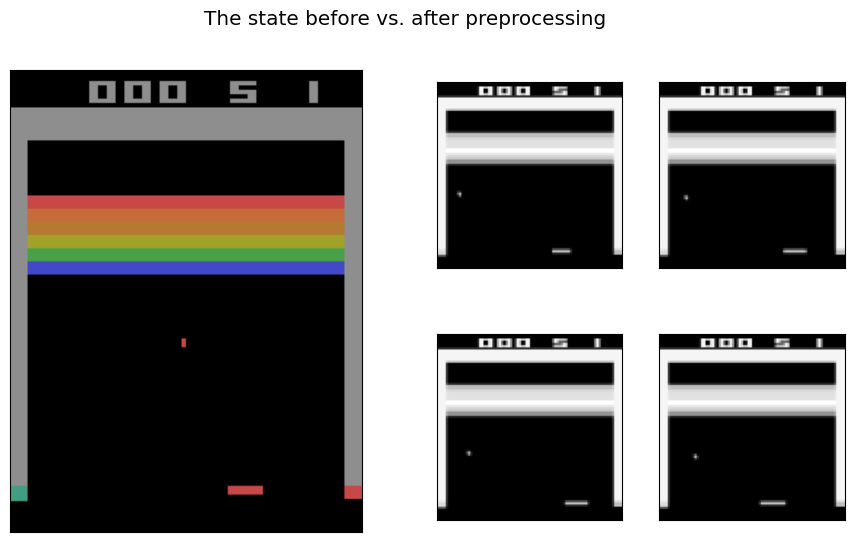

  0%|          | 0/12500 [00:00<?, ?it/s]

In [ ]:
# Initialize replay memory
env = initialize_env(show_comparison=True)
replay_memory = ReplayMemory(env, MIN_REPLAY_SIZE, BUFFER_SIZE, device)

In [ ]:
# Initialize Q-networks
online_net = Net(env, device).to(device)
target_net = Net(env, device).to(device)

# Initalize and copy weights
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        m.bias.data.fill_(0.0)

    if type(m) == nn.Conv2d:
        torch.nn.init.kaiming_normal_(m.weight, nonlinearity='relu')

online_net.apply(init_weights)
target_net.load_state_dict(online_net.state_dict())

# Initialize optimizer
optimizer = torch.optim.Adam(online_net.parameters(), lr=ALPHA)

## Training

The training loop is quite similar to tabular Q-learning, the main difference is the way the updates are handled: instead of updating the Q-values every time based
on the current transition, we store the transition in the reward buffer, and sample a batch of transitions every `OPTIM_FREQ` (default: 4) steps.

In [ ]:
# Initialize environment
env = initialize_env(recording=True)

# Initialize log data
rew_buffer = deque([0.], maxlen=80)
loss_buffer = deque([0.], maxlen=80)
n_steps = 0
online_net.train()

# Training loop
for episode in (t := trange(N_EPISODES)):
    # Set tqdm description
    t.set_description(f"Avg. loss: {np.mean(loss_buffer):.4f} | Avg. reward: {np.mean(rew_buffer):.2f}")
    t.refresh()

    # Reset environment
    state, _ = env.reset()
    action = 0
    done = False
    life_lost = False
    episode_reward = 0.
    lives = env.ale.lives()

    while not done:
        # Epsilon-greedy action selection
        if np.random.rand() < EPSILON:
            action = env.action_space.sample()
        else:
            action = online_net.act(state)

        # Take selected action
        new_state, reward, terminated, truncated, _ = env.step(action)

        # Update lives
        life_lost = env.ale.lives() < lives
        lives = env.ale.lives()

        # Store transition in replay memory
        transition = (state, action, reward, new_state, life_lost or terminated)
        replay_memory.append(transition)

        episode_reward += reward
        state = new_state
        done = terminated or truncated

        # Optimization step
        if n_steps % OPTIM_FREQ == 0:
            states, actions, rewards, new_states, terminateds = replay_memory.sample(BATCH_SIZE)

            # Compute targets
            with torch.no_grad():
                target_q_values = target_net(new_states)
                max_target_q_values = target_q_values.max(dim=1, keepdim=True)[0]
                targets = rewards + GAMMA * (1 - terminateds) * max_target_q_values

            # Compute loss
            q_values = online_net(states)
            action_q_values = torch.gather(input=q_values, dim=1, index=actions)
            loss = F.smooth_l1_loss(action_q_values, targets)
            loss_buffer.append(loss.item())

            # Optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Update target network
        if n_steps % TARGET_UPDATE_FREQ == 0:
            target_net.load_state_dict(online_net.state_dict())

        # Update reward buffer
        if done:
            rew_buffer.append(episode_reward)

        n_steps += 1

    # Update epsilon
    EPSILON = max(EPSILON - EPSILON_DECAY, EPSILON_MIN)

    # Save model
    if (episode + 1) % SAVE_FREQ == 0:
        model_scripted = torch.jit.script(online_net)  # Export to TorchScript
        model_scripted.save('model_scripted.pt')  # Save

  0%|          | 0/4000 [00:00<?, ?it/s]

## Results

You can watch the videos recorded throughout the training process here:

In [ ]:
# Display recordings
children = [widgets.Video.from_file(f'./videos/rl-video-episode-{episode}.mp4', autoplay=False, loop=False, width=500) for episode in REC_EPISODES]
tab = widgets.Tab()
tab.children = children
titles = tuple([f'Episode {episode + 1}' for episode in REC_EPISODES])
for i in range(len(children)):
    tab.set_title(i, titles[i])
display(tab)